In [112]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.integrate as integrate
import scipy.optimize as optimize

In [113]:
plt.style.use("../style1.mplstyle")

In [114]:
@njit
def chemostat_dynamics(t,y,args):
    mu,k,yiel,delta,s = args
    n,c = y
    dn = mu * n * c / (k + c) - delta * n
    dc = delta*(s-c) - mu * n/yiel * c / (k + c)

    return np.array([dn,dc])

In [115]:
mu = 0.703 
delta = 0.05
k = 7.721
s = 10
yiel = 0.1

In [116]:
initialn = 0.05
initialc = s
teval = np.linspace(0,200,1000)

In [117]:
soln_n = integrate.solve_ivp(chemostat_dynamics, (0,teval[-1]), [initialn,initialc], args=((mu,k,yiel,delta,s),), t_eval=teval)

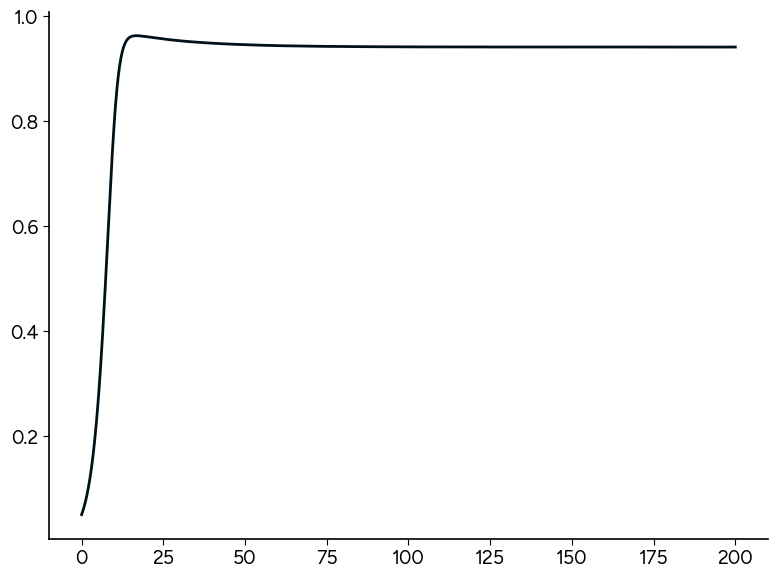

In [118]:
plt.plot(teval,soln_n.y[0],label="OD")


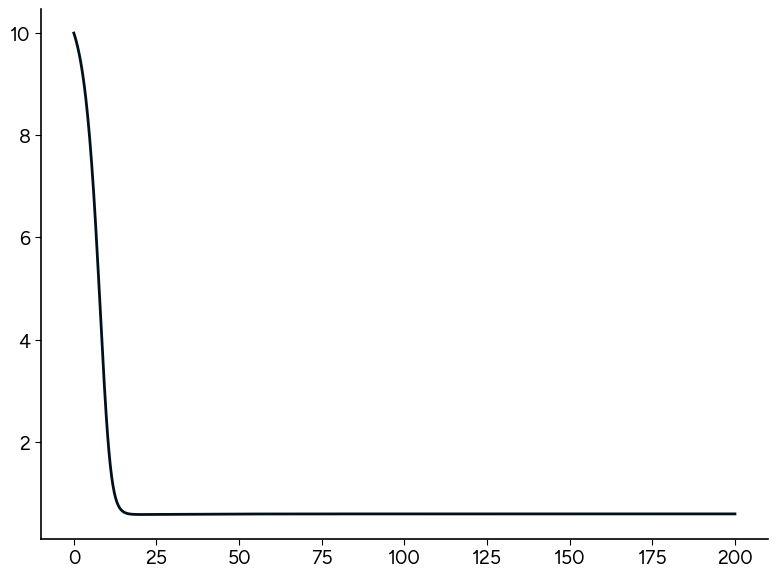

In [119]:
plt.plot(teval,soln_n.y[1],label="Resource")


In [120]:
@njit
def glv_rhs(t,y,g,alpha):
    dydot = y*(g - alpha*y)
    return dydot

In [121]:
def logistic_solution(t,g,alpha,x0):
    return x0 * g/alpha  / ((g/alpha - x0)*np.exp(-g*t) + x0)

theory_soln = lambda t,g,alpha: logistic_solution(t,g,alpha,initialn)

In [122]:
def glv_error(params,chemostatSoln):
    gvec,alphamatrix = params
    integrated_soln = integrate.solve_ivp(glv_rhs,[0,teval[-1]],[initialn],args=(gvec,alphamatrix),t_eval=teval,rtol=1e-6,atol=1e-6)
    try:
        error = np.sum((integrated_soln.y[0] - chemostatSoln)**2)
    except:
        print(params)
        integrated_soln
    return np.sum((integrated_soln.y[0] - chemostatSoln)**2)

In [123]:
glv_lsq = optimize.minimize(glv_error,[0.1,0.1],args=(soln_n.y[0]),method="Nelder-Mead",bounds=[(0,None),(0,None)])

g,alpha = glv_lsq.x

print(g,alpha)

0.4318193989213349 0.45700426247227627


In [124]:
mu*s/(k+s)

0.39670447491676536

In [125]:
logbins = np.geomspace(np.min(kmvals),np.max(kmvals),int(kmvals.size/20))

In [126]:
kmvals = np.loadtxt("km.txt")

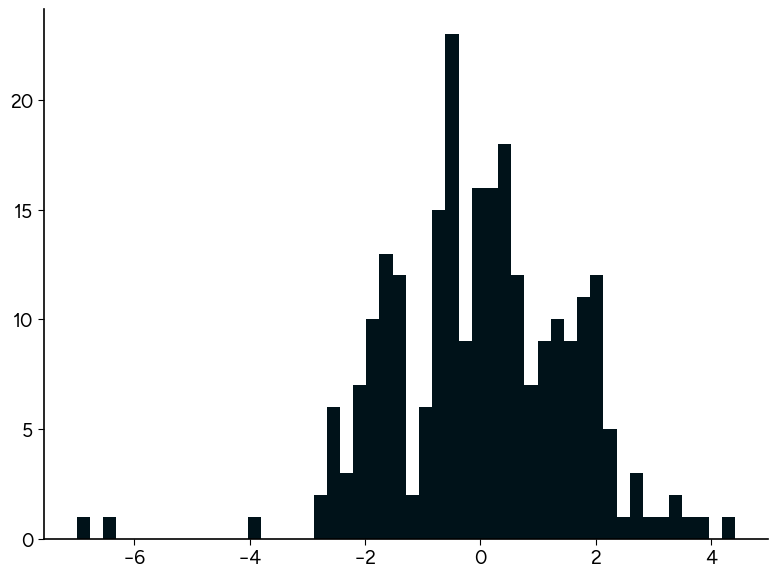

In [127]:
plt.hist(np.log10(kmvals),bins=50)
# plt.yscale('log')

plt.show()

In [128]:
soln_glv_bootstrap = integrate.solve_ivp(glv_rhs,[0,teval[-1]],[initialn],args=(0.4334305319190024,0.459358947128054),t_eval=teval,rtol=1e-6,atol=1e-6)

In [129]:
fitvals,fitcorr  = optimize.curve_fit(theory_soln,teval,soln_n.y[0],p0=[1,1],bounds=([0,0],[np.inf,np.inf]))

g,alpha = fitvals
print(g,alpha)

soln_glv_theoryfit = integrate.solve_ivp(glv_rhs, (0,teval[-1]), [initialn], args=(g,np.array([[alpha]])), t_eval=teval)

0.43187164107788395 0.45705806341073846


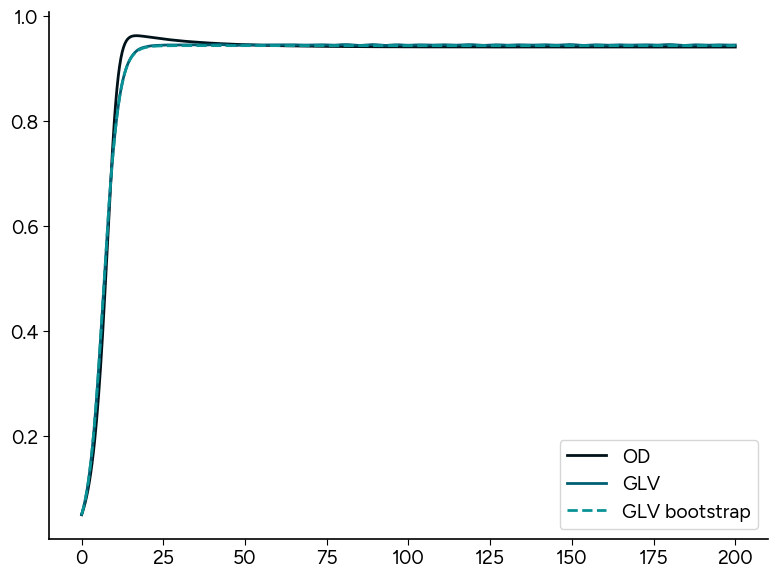

In [130]:
plt.plot(teval,soln_n.y[0],label="OD")
plt.plot(teval,soln_glv_theoryfit.y[0],label="GLV")
plt.plot(teval,soln_glv_bootstrap.y[0],label="GLV bootstrap",ls="--")

plt.legend()

In [131]:
def testfn(c,n,mu,yiel,k,delta,s):
    return mu* k*n / (k+c)**2 / delta / yiel

In [132]:
plotnarray = np.linspace(0.01,1,1000)
plotcarrray = np.linspace(0.01,10,1000)

plotn,plotc = np.meshgrid(plotnarray,plotcarrray)

plotfn = testfn(plotc,plotn,mu,yiel,k,delta,s)

In [133]:
oneLocs = np.where(plotfn == 1)

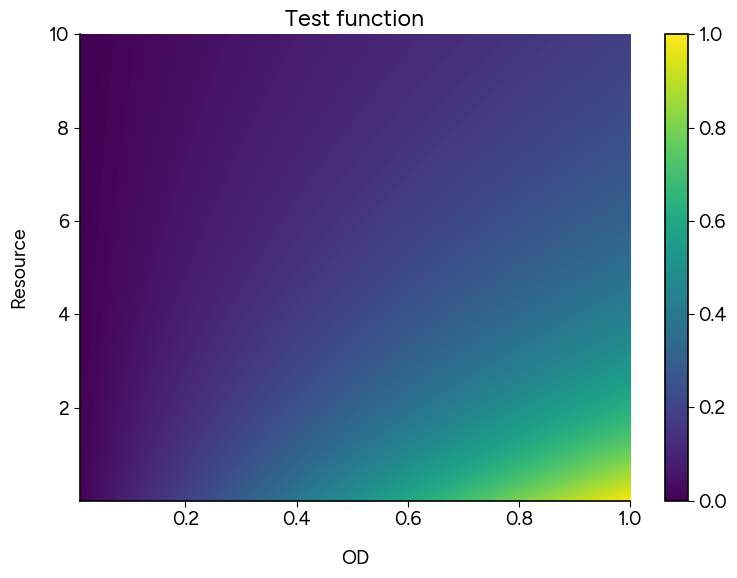

In [134]:
plt.figure()
plt.imshow((plotfn),extent=(0.01,1,0.01,10),origin="lower",aspect="auto",cmap="viridis")
plt.scatter(plotnarray[oneLocs[0]],plotcarrray[oneLocs[1]],c="red")
# plt.yscale("log")
plt.colorbar()
plt.xlabel("OD")
plt.ylabel("Resource")
plt.title("Test function")
plt.show()

In [135]:
def glv_approx_params(c,mu,k,yiel,delta,s):
    sij = mu*k / (k+c)**2
    fi = delta*(s-c) 
    df_de = -delta
    eC = mu*c / (k+c) / yiel
    de_dE = mu*k / (k+c)**2 / yiel

    mij = de_dE / eC * fi - df_de
    gcalc = fi / mij / sij
    alphacalc = eC / sij/mij
    return gcalc,alphacalc

In [136]:
def third_order_approx(c,mu,k,yiel,delta,s):
    sij = mu*k / (k+c)**2
    fi = delta*(s-c) 
    df_de = -delta
    eC = mu*c / (k+c) / yiel
    de_dE = mu*k / (k+c)**2 / yiel

    minv = 1/delta * (1+ mu*k*f/eC / delta / yiel / (k+c)**2)
    gcalc = fi *minv / sij
    alphacalc = eC / sij * minv
    return gcalc,alphacalc

In [137]:
def qssC(n,mu,k,yiel,delta,s):
    bterm = (-s + k + n*mu/delta/yiel)
    aterm = 1
    cterm = -s * k
    return (-bterm + np.sqrt(bterm**2 - 4*aterm*cterm))/(2*aterm)

In [138]:
qssCvsT = np.array([qssC(n,mu,k,yiel,delta,s) for n in soln_n.y[0]])

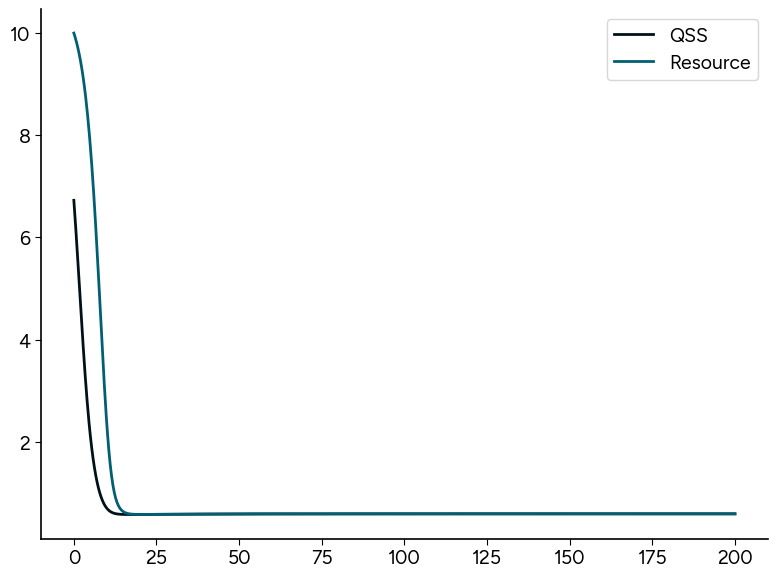

In [139]:
plt.plot(teval,qssCvsT,label="QSS")
plt.plot(teval,soln_n.y[1],label="Resource")

plt.legend()

In [140]:
paramsOfApprox = glv_approx_params(qssCvsT[-1],mu,k,yiel,delta,s)
paramsApproxTimeTraj = np.array([glv_approx_params(c,mu,k,yiel,delta,s) for c in qssCvsT])

In [141]:
paramsOfApprox

(7.588525118342265, 8.065494807267758)

In [142]:
glv_approx_params(qssCvsT[-1],mu,k,yiel,delta,s),glv_approx_params(soln_n.y[1][-1],mu,k,yiel,delta,s)

((7.588525118342265, 8.065494807267758), (7.59127544231882, 8.07095836817181))

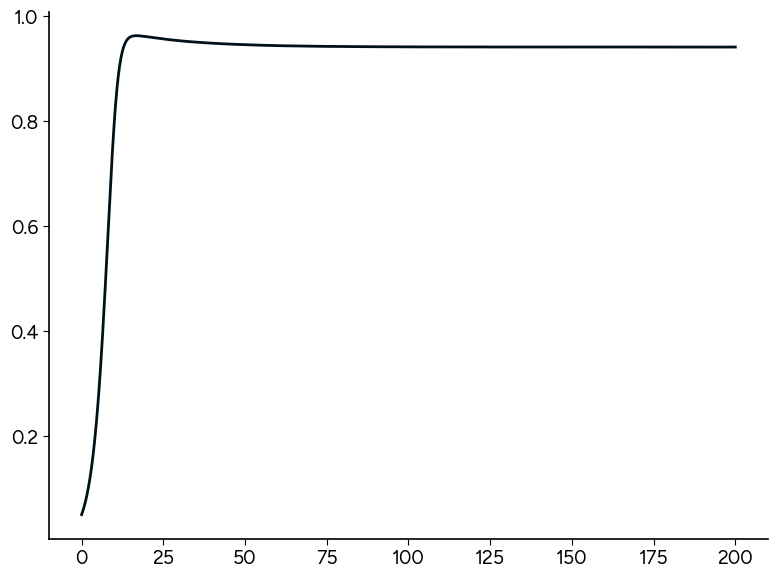

In [143]:
plt.plot(teval,paramsApproxTimeTraj[:,0]/paramsApproxTimeTraj[:,1],label="QSS C")

In [144]:
paramsOfApprox[1]/paramsOfApprox[0]

1.0628540699921527

In [145]:
fitvals[1]/fitvals[0]

1.0583192317744994

In [146]:
print(paramsOfApprox)
print(fitvals)

(7.588525118342265, 8.065494807267758)
[0.43187164 0.45705806]


In [147]:
soln_n.y[0][-1]

0.9408629352168723

In [148]:
qssC(soln_n.y[0][-1],mu,k,yiel,delta,s)

0.5912056486373984

In [149]:
soln_n.y[1][-1]

0.5913933478445244

In [150]:
soln_n.y[0][-1]

0.9408629352168723

In [151]:
mu,k,yiel,delta,s

(0.703, 7.721, 0.1, 0.05, 10)

In [152]:
@njit
def timeDepGLV(t,y,g,alpha):
    return y*(g - alpha*y)

In [153]:
gTime = paramsApproxTimeTraj[:,0]
alphaTime = paramsApproxTimeTraj[:,1]

In [154]:
@njit
def rk4Integrator(func,t,y,dt,args):
    k1 = dt*func(t,y,*args)
    k2 = dt*func(t+dt/2,y+k1/2,*args)
    k3 = dt*func(t+dt/2,y+k2/2,*args)
    k4 = dt*func(t+dt,y+k3,*args)
    return y + (k1 + 2*k2 + 2*k3 + k4)/6

In [155]:
timeDepN = np.zeros_like(soln_n.y[0])
timeDepN[0] = initialn
dt = teval[1] - teval[0]

for i in range(1,len(teval)):
    timeDepN[i] = rk4Integrator(timeDepGLV,teval[i-1],timeDepN[i-1],dt,(gTime[i-1],alphaTime[i-1]))
    

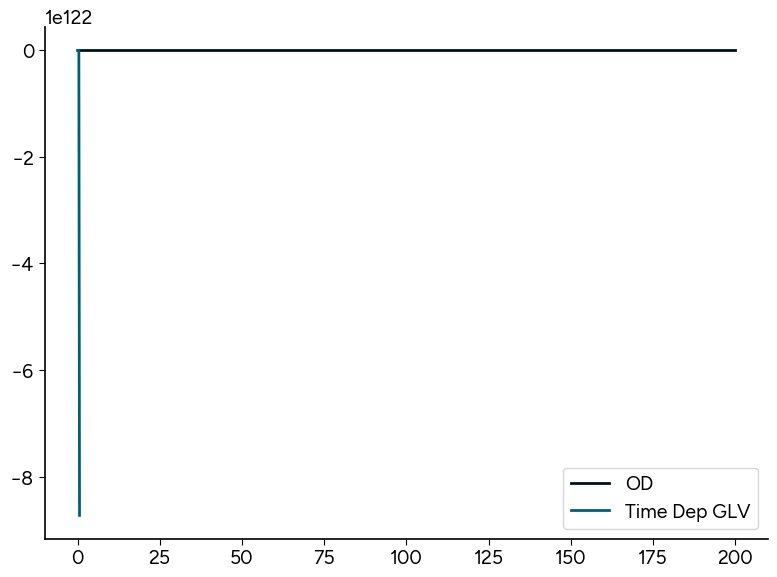

In [156]:
plt.plot(teval,soln_n.y[0],label="OD")
plt.plot(teval,timeDepN,label="Time Dep GLV")

plt.legend()

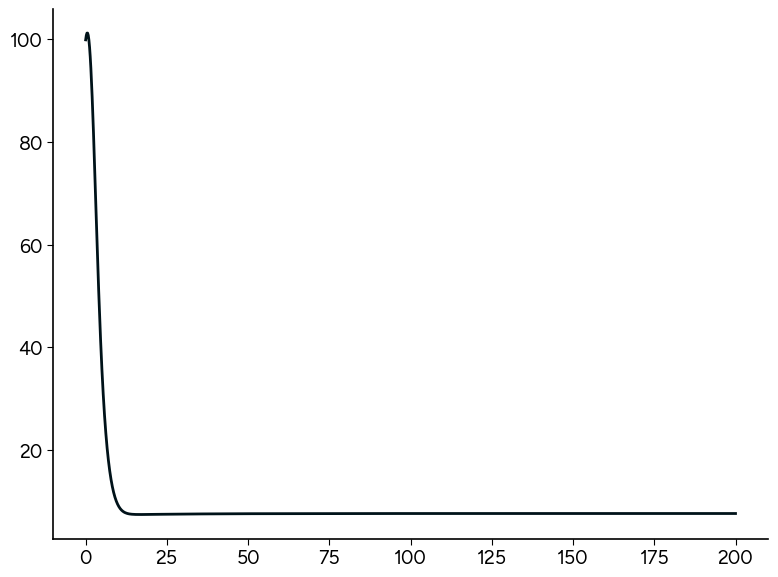

In [157]:
plt.plot(teval,gTime)


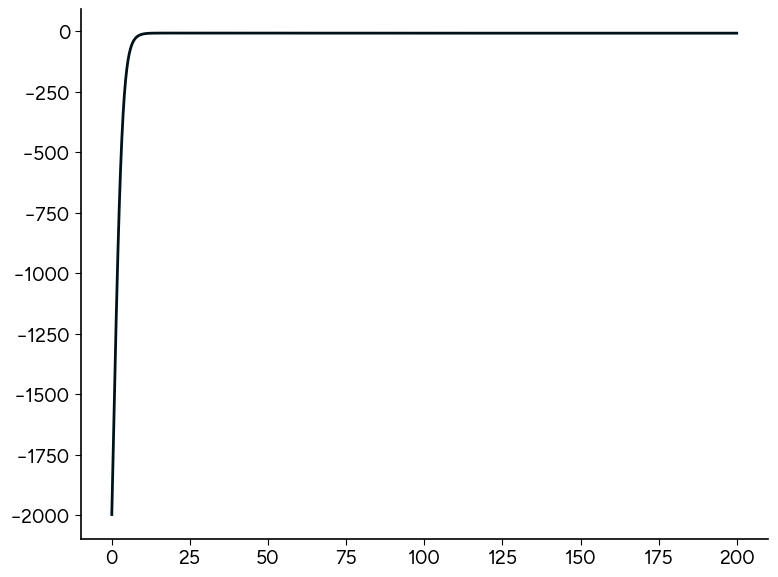

In [158]:
plt.plot(teval,-alphaTime)

In [170]:
fullFitArray = np.load("data/fullFitArray_2.npy")
qssFitArray = np.load("data/qssFitArray_2.npy")

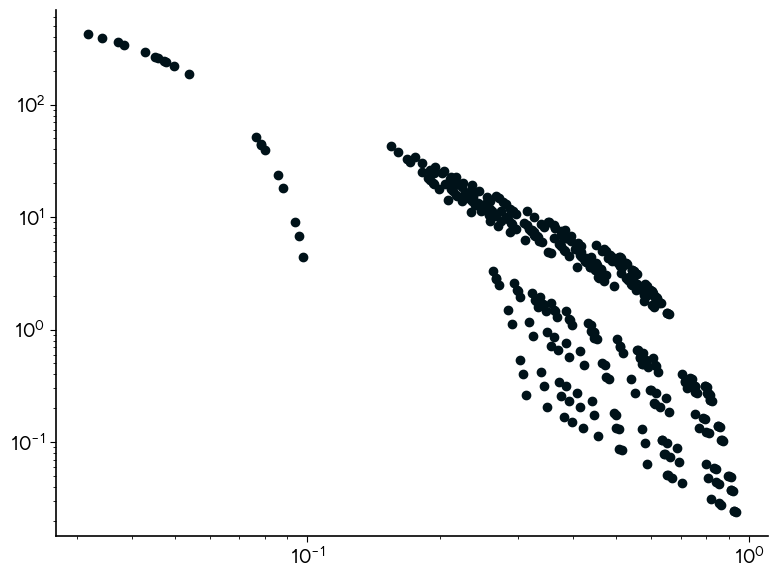

In [171]:
plt.scatter(fullFitArray[:,:,0].flatten(),qssFitArray[:,:,0].flatten())

plt.xscale("log")
plt.yscale("log")
plt.show()

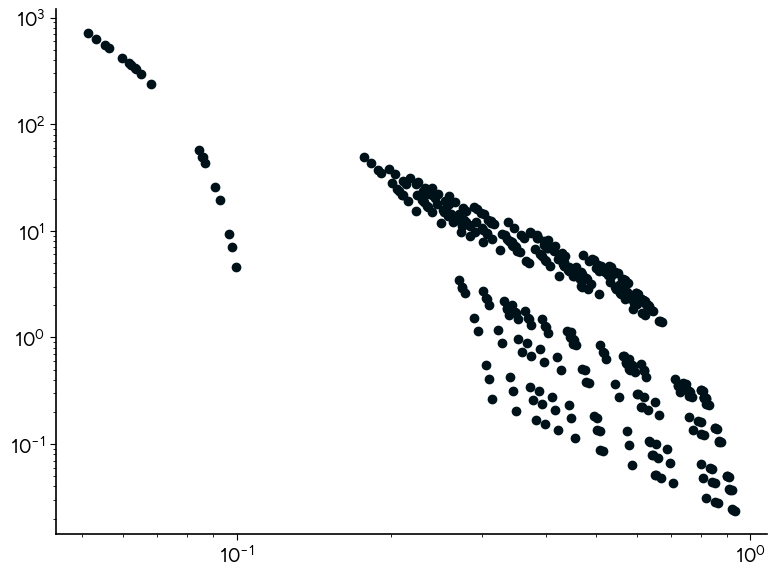

In [176]:
plt.scatter(fullFitArray[:,:,1].flatten(),qssFitArray[:,:,1].flatten())

plt.xscale("log")
plt.yscale("log")
plt.show()